# Code for Effective Pandas by Matt Harrison talk

tl;dr
This code was inspired by Matt Harrison's presentation, [Effective Pandas](https://youtu.be/UURvPeczxJI). In the presentation, Matt shows the following:
1. Reducing the memory cost using `Casting` [[1](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)], which is a method to turn a data type of an object into another data type. From Matt's experiment, we saved `65.17% (10.97MB)` from the original data. This could be improved even further by casting other columns.
2. Writing `Pandas` operations in a cleaner and efficient way using ~~[Dot Notion](https://www.dataschool.io/pandas-dot-notation-vs-brackets/)~~ [Chaining](https://changhsinlee.com/pyjanitor/).
3. Comparing `.apply` method with other methods to broadcast operations.

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


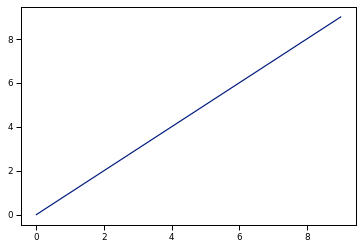

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.min_rows = 20 # show more rows
print(plt.style.available) # show avaiable themes
plt.style.use('seaborn-dark-palette') # select a theme
# https://seaborn.pydata.org/generated/seaborn.set_context.html
sns.set_context('paper') # talk, paper, notebook, poster
plt.plot(range(10)) # to view for myself
plt.show()

In [2]:
data_source = "https://github.com/mattharrison/datasets/raw/master/data/vehicles.csv.zip"
autos = pd.read_csv(data_source)

/home/alotaima/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (68,70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
cols = ['city08','comb08', 'cylinders', 'displ', 'drive', 'eng_dscr', 'trany', 'fuelCost08', 'highway08','make','range','year','createdOn']

In [4]:
print("show dtypes")
print(autos[cols].dtypes)
# int64 == means no missing data
# float64 == means 1. all float numbers with no missing data 2. all float numbers with missing data 3. or all int numbers with missing data
# object == means can't tell if it is int or not (not super fast as it points to python objects)
display((autos
    [cols]
    .select_dtypes(int)
    .describe()
))
old_mem = autos[cols].memory_usage(deep=True).sum()
print(f"{(old_mem)/1000000:.2f}MB")

show dtypes
city08          int64
comb08          int64
cylinders     float64
displ         float64
drive          object
eng_dscr       object
trany          object
fuelCost08      int64
highway08       int64
make           object
range           int64
year            int64
createdOn      object
dtype: object


,city08,comb08,fuelCost08,highway08,range,year
count,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,2362.335942,24.504667,0.793506,2001.535266
std,7.905886,7.674535,654.981925,7.730364,13.041592,11.142414
min,6.000000,7.000000,500.000000,9.000000,0.000000,1984.000000
25%,15.000000,17.000000,1900.000000,20.000000,0.000000,1991.000000
50%,17.000000,20.000000,2350.000000,24.000000,0.000000,2002.000000
75%,20.000000,23.000000,2700.000000,28.000000,0.000000,2011.000000
max,150.000000,136.000000,7400.000000,124.000000,370.000000,2020.000000


16.83MB


# Casting as Integer

In [5]:
# cast highway08 as int8 and city08 & comb08 as int16
print("show int8 and int16 range")
print(np.iinfo(np.int8))
print(np.iinfo(np.int16))

print("cast highway08, city08, and comb08 as int")
display((
    autos
    [cols]
    .astype({'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16'})
    # .select_dtypes([int, 'int8'])
    .select_dtypes(['integer']) # select integer like
    .describe()
))
new_mem = (autos
    [cols]
    .astype({'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16'})
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show int8 and int16 range
Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

cast highway08, city08, and comb08 as int


,city08,comb08,fuelCost08,highway08,range,year
count,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,2362.335942,24.504667,0.793506,2001.535266
std,7.905886,7.674535,654.981925,7.730364,13.041592,11.142414
min,6.000000,7.000000,500.000000,9.000000,0.000000,1984.000000
25%,15.000000,17.000000,1900.000000,20.000000,0.000000,1991.000000
50%,17.000000,20.000000,2350.000000,24.000000,0.000000,2002.000000
75%,20.000000,23.000000,2700.000000,28.000000,0.000000,2011.000000
max,150.000000,136.000000,7400.000000,124.000000,370.000000,2020.000000


4.64% (0.78MB)


# Remove NaN

In [6]:
# remove NaN from cylinders & displ and cast cylinders as int8
print("show columns with dtype as float")
display((
    autos
    [cols]
    .select_dtypes('float')
))
print("show cylinders' summary")
print(autos.cylinders.describe()) # it has missing values (41144 != 40938)
print("show cylinders' values (including NaN)")
print(autos.cylinders.value_counts(dropna=False)) # show NaN
# where are they missing?
print("show rows with NaN values for cylinders")
display((
    autos
    [cols]
    .query('cylinders.isna()',engine='python')
))
print("remove NaN values in cylinders & displ and cast cylinders as int")
# add cylinders and displ columns
display((
    autos
    [cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'), # updating columns with new values, cylinderes is filled with 0 when NaN and then converted to int8
            displ=autos.displ.fillna(0)) # displ is filled with 0 when NaN
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16',})
    .describe()
))
new_mem = (
    autos
    [cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'), # updating columns with new values, cylinderes is filled with 0 when NaN and then converted to int8
            displ=autos.displ.fillna(0)) # displ is filled with 0 when NaN
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16',})
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show columns with dtype as float


,cylinders,displ
0,4.0,2.0
1,12.0,4.9
2,4.0,2.2
3,8.0,5.2
4,4.0,2.2
5,4.0,1.8
6,4.0,1.8
7,4.0,1.6
8,4.0,1.6
9,4.0,1.8


show cylinders' summary
count    40938.000000
mean         5.717084
std          1.755517
min          2.000000
25%          4.000000
50%          6.000000
75%          6.000000
max         16.000000
Name: cylinders, dtype: float64
show cylinders' values (including NaN)
4.0     15938
6.0     14284
8.0      8801
5.0       771
12.0      626
3.0       279
NaN       206
10.0      170
2.0        59
16.0       10
Name: cylinders, dtype: int64
show rows with NaN values for cylinders


,city08,comb08,cylinders,displ,drive,eng_dscr,trany,fuelCost08,highway08,make,range,year,createdOn
7138,81,85,NaN,NaN,NaN,NaN,NaN,800,91,Nissan,90,2000,Tue Jan 01 00:00:00 EST 2013
7139,81,72,NaN,NaN,2-Wheel Drive,NaN,NaN,900,64,Toyota,88,2000,Tue Jan 01 00:00:00 EST 2013
8143,81,72,NaN,NaN,2-Wheel Drive,NaN,NaN,900,64,Toyota,88,2001,Tue Jan 01 00:00:00 EST 2013
8144,74,65,NaN,NaN,NaN,NaN,NaN,1000,58,Ford,29,2001,Tue Jan 01 00:00:00 EST 2013
8146,45,39,NaN,NaN,2-Wheel Drive,NaN,NaN,1700,33,Ford,38,2001,Tue Jan 01 00:00:00 EST 2013
8147,84,75,NaN,NaN,NaN,NaN,NaN,900,66,Nissan,33,2001,Tue Jan 01 00:00:00 EST 2013
9212,87,78,NaN,NaN,2-Wheel Drive,NaN,NaN,850,69,Toyota,95,2002,Tue Jan 01 00:00:00 EST 2013
9213,45,39,NaN,NaN,2-Wheel Drive,NaN,NaN,1700,33,Ford,38,2002,Tue Jan 01 00:00:00 EST 2013
10329,87,78,NaN,NaN,2-Wheel Drive,NaN,NaN,850,69,Toyota,95,2003,Tue Jan 01 00:00:00 EST 2013
21413,22,24,NaN,NaN,4-Wheel Drive,NaN,Manual 5-spd,1750,28,Subaru,0,1985,Tue Jan 01 00:00:00 EST 2013


remove NaN values in cylinders & displ and cast cylinders as int


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year
count,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,3.277904,2362.335942,24.504667,0.793506,2001.535266
std,7.905886,7.674535,1.797009,1.373415,654.981925,7.730364,13.041592,11.142414
min,6.000000,7.000000,0.000000,0.000000,500.000000,9.000000,0.000000,1984.000000
25%,15.000000,17.000000,4.000000,2.200000,1900.000000,20.000000,0.000000,1991.000000
50%,17.000000,20.000000,6.000000,3.000000,2350.000000,24.000000,0.000000,2002.000000
75%,20.000000,23.000000,6.000000,4.300000,2700.000000,28.000000,0.000000,2011.000000
max,150.000000,136.000000,16.000000,8.400000,7400.000000,124.000000,370.000000,2020.000000


10.75% (1.81MB)


# Casting as Float

In [7]:
# cast displ as float
print("show float16 range")
print(np.finfo(np.float16))
print("cast displ as float")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'))
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16',})
))
new_mem = (
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'))
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16',})
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show float16 range
Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
---------------------------------------------------------------

cast displ as float


,city08,comb08,cylinders,displ,drive,eng_dscr,trany,fuelCost08,highway08,make,range,year,createdOn
0,19,21,4,2.000000,Rear-Wheel Drive,(FFS),Manual 5-spd,2000,25,Alfa Romeo,0,1985,Tue Jan 01 00:00:00 EST 2013
1,9,11,12,4.898438,Rear-Wheel Drive,(GUZZLER),Manual 5-spd,3850,14,Ferrari,0,1985,Tue Jan 01 00:00:00 EST 2013
2,23,27,4,2.199219,Front-Wheel Drive,(FFS),Manual 5-spd,1550,33,Dodge,0,1985,Tue Jan 01 00:00:00 EST 2013
3,10,11,8,5.199219,Rear-Wheel Drive,NaN,Automatic 3-spd,3850,12,Dodge,0,1985,Tue Jan 01 00:00:00 EST 2013
4,17,19,4,2.199219,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",Manual 5-spd,2700,23,Subaru,0,1993,Tue Jan 01 00:00:00 EST 2013
5,21,22,4,1.799805,Front-Wheel Drive,(FFS),Automatic 3-spd,1900,24,Subaru,0,1993,Tue Jan 01 00:00:00 EST 2013
6,22,25,4,1.799805,Front-Wheel Drive,(FFS),Manual 5-spd,1700,29,Subaru,0,1993,Tue Jan 01 00:00:00 EST 2013
7,23,24,4,1.599609,Front-Wheel Drive,(FFS),Automatic 3-spd,1750,26,Toyota,0,1993,Tue Jan 01 00:00:00 EST 2013
8,23,26,4,1.599609,Front-Wheel Drive,(FFS),Manual 5-spd,1600,31,Toyota,0,1993,Tue Jan 01 00:00:00 EST 2013
9,23,25,4,1.799805,Front-Wheel Drive,(FFS),Automatic 4-spd,1700,30,Toyota,0,1993,Tue Jan 01 00:00:00 EST 2013


12.22% (2.06MB)


# Casting Objects as Category

In [8]:
# show objects
print("show columns with dtype as object")
(
    autos[cols]
    .select_dtypes(object) # object that could be turned to categorical
)
# show drive's values
print("show drive's values (including NaN)")
(
    autos
    .drive.value_counts(dropna=False)
)
# show NaN
print("show rows with NaN values for drive")
(
    autos[cols]
    .query('drive.isna()',engine='python')
)
# show unique values based on year
print("show show unique values based on year")
(
    autos[cols]
    .groupby('year')
    .drive
    .nunique()
)
# # drive and make (in .astype) to category
# # converting two columns to categorical column
print("remove NaN values in drive and cast drive as category")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'))
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .describe()
))
new_mem = (
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'))
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show columns with dtype as object
show drive's values (including NaN)
show rows with NaN values for drive
show show unique values based on year
remove NaN values in drive and cast drive as category


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year
count,41144.000000,41144.000000,41144.000000,4.114400e+04,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,inf,2362.335942,24.504667,0.793506,2001.535266
std,7.905886,7.674535,1.797009,1.373047e+00,654.981925,7.730364,13.041592,11.142414
min,6.000000,7.000000,0.000000,0.000000e+00,500.000000,9.000000,0.000000,1984.000000
25%,15.000000,17.000000,4.000000,2.199219e+00,1900.000000,20.000000,0.000000,1991.000000
50%,17.000000,20.000000,6.000000,3.000000e+00,2350.000000,24.000000,0.000000,2002.000000
75%,20.000000,23.000000,6.000000,4.300781e+00,2700.000000,28.000000,0.000000,2011.000000
max,150.000000,136.000000,16.000000,8.398438e+00,7400.000000,124.000000,370.000000,2020.000000


44.87% (7.55MB)


# Casting as Category

In [9]:
# cast trany as category of automatic & speeds
print("show trany's values (including NaN)")
display((
    autos
    .trany.value_counts(dropna=False)
))
# drive and make (in .astype) to category
# converting two columns to categorical column
print("create two new columns: automatic and speeds")
print("authomatic: values that contain 'Auto' from trany column")
print("speeds: decimal values from trany column and fill NaN then cast as int")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8') # pull the digits from trany column
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .describe()
))
new_mem = (
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8') # pull the digits from trany column
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show trany's values (including NaN)


Automatic 4-spd                     11047
Manual 5-spd                         8361
Automatic 3-spd                      3151
Automatic (S6)                       3106
Manual 6-spd                         2757
Automatic 5-spd                      2203
Automatic (S8)                       1665
Automatic 6-spd                      1619
Manual 4-spd                         1483
Automatic (S5)                        833
Automatic (variable gear ratios)      826
Automatic 7-spd                       724
Automatic 8-spd                       433
Automatic (AM-S7)                     424
Automatic (S7)                        327
Automatic 9-spd                       293
Automatic (AM7)                       245
Automatic (S4)                        233
Automatic (AV-S6)                     208
Automatic (A1)                        201
Automatic (AM6)                       151
Automatic (AV-S7)                     139
Automatic (S10)                       124
Automatic (AM-S6)                 

create two new columns: automatic and speeds
authomatic: values that contain 'Auto' from trany column
speeds: decimal values from trany column and fill NaN then cast as int


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year,speeds
count,41144.000000,41144.000000,41144.000000,4.114400e+04,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,inf,2362.335942,24.504667,0.793506,2001.535266,5.286141
std,7.905886,7.674535,1.797009,1.373047e+00,654.981925,7.730364,13.041592,11.142414,2.512561
min,6.000000,7.000000,0.000000,0.000000e+00,500.000000,9.000000,0.000000,1984.000000,0.000000
25%,15.000000,17.000000,4.000000,2.199219e+00,1900.000000,20.000000,0.000000,1991.000000,4.000000
50%,17.000000,20.000000,6.000000,3.000000e+00,2350.000000,24.000000,0.000000,2002.000000,5.000000
75%,20.000000,23.000000,6.000000,4.300781e+00,2700.000000,28.000000,0.000000,2011.000000,6.000000
max,150.000000,136.000000,16.000000,8.398438e+00,7400.000000,124.000000,370.000000,2020.000000,20.000000


53.56% (9.02MB)


# Casting as Date

In [10]:
# cast createdOn as date
# add createdOn (Python doesn't like EST/EDT format)
print("cast createdOn as Date, but Python doesn't like EST/EDT format")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn).dt.tz_localize('America/New_York').dt.tz_convert('UTC')
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .describe()
))
# fix date warning
print("cast createdOn as Date with the right fix")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True))
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .describe()
))
new_mem = (
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True))
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")


cast createdOn as Date, but Python doesn't like EST/EDT format


/home/alotaima/miniconda3/lib/python3.9/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/home/alotaima/miniconda3/lib/python3.9/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year,speeds
count,41144.000000,41144.000000,41144.000000,4.114400e+04,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,inf,2362.335942,24.504667,0.793506,2001.535266,5.286141
std,7.905886,7.674535,1.797009,1.373047e+00,654.981925,7.730364,13.041592,11.142414,2.512561
min,6.000000,7.000000,0.000000,0.000000e+00,500.000000,9.000000,0.000000,1984.000000,0.000000
25%,15.000000,17.000000,4.000000,2.199219e+00,1900.000000,20.000000,0.000000,1991.000000,4.000000
50%,17.000000,20.000000,6.000000,3.000000e+00,2350.000000,24.000000,0.000000,2002.000000,5.000000
75%,20.000000,23.000000,6.000000,4.300781e+00,2700.000000,28.000000,0.000000,2011.000000,6.000000
max,150.000000,136.000000,16.000000,8.398438e+00,7400.000000,124.000000,370.000000,2020.000000,20.000000


cast createdOn as Date with the right fix


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year,speeds
count,41144.000000,41144.000000,41144.000000,4.114400e+04,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,inf,2362.335942,24.504667,0.793506,2001.535266,5.286141
std,7.905886,7.674535,1.797009,1.373047e+00,654.981925,7.730364,13.041592,11.142414,2.512561
min,6.000000,7.000000,0.000000,0.000000e+00,500.000000,9.000000,0.000000,1984.000000,0.000000
25%,15.000000,17.000000,4.000000,2.199219e+00,1900.000000,20.000000,0.000000,1991.000000,4.000000
50%,17.000000,20.000000,6.000000,3.000000e+00,2350.000000,24.000000,0.000000,2002.000000,5.000000
75%,20.000000,23.000000,6.000000,4.300781e+00,2700.000000,28.000000,0.000000,2011.000000,6.000000
max,150.000000,136.000000,16.000000,8.398438e+00,7400.000000,124.000000,370.000000,2020.000000,20.000000


60.65% (10.21MB)


# Casting as Category for columns with multiple values

In [11]:
# cast eng_dscr as category of ffs
print("show eng_dscr's values (including NaN)")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True)),
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany'])
    .eng_dscr
    .value_counts(dropna=False)
))
# add ffs (Feedback fuel system), drop eng_dscr
print("create a new column: ffs")
print("ffs: values that contain 'FFS' from eng_dscr column")
display((
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True)),
            ffs=autos.eng_dscr.str.contains('FFS'),
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany', 'eng_dscr'])
    .describe()
))
new_mem = (
    autos[cols]
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
            displ=autos.displ.fillna(0).astype('float16'),
            drive=autos.drive.fillna('Other').astype('category'),
            automatic=autos.trany.str.contains('Auto'),
            speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
            createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True)),
            ffs=autos.eng_dscr.str.contains('FFS'),
    )
    .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
    .drop(columns=['trany', 'eng_dscr'])
    .memory_usage(deep=True)
    .sum()
)
print(f"{100 - new_mem/old_mem * 100:.2f}% ({(old_mem-new_mem)/1000000:.2f}MB)")

show eng_dscr's values (including NaN)


NaN                                 16153
(FFS)                                8827
SIDI                                 5526
(FFS) CA model                        926
(FFS)      (MPFI)                     734
FFV                                   701
(FFS,TRBO)                            666
(350 V8) (FFS)                        411
(GUZZLER)  (FFS)                      366
SOHC                                  354
                                    ...  
B234L/R4 (FFS,TRBO)                     1
GUZZLER V8 FFS,TURBO                    1
4.6M FFS MPFI                           1
CNG FFS                                 1
POLICE FFS MPFI                         1
B308E5 FFS,TURBO                        1
5.4E-R FFS MPFI                         1
V-6 FFS                                 1
(GUZZLER)  (FFS)      (S-CHARGE)        1
R-ENG (FFS,TRBO)                        1
Name: eng_dscr, Length: 558, dtype: int64

create a new column: ffs
ffs: values that contain 'FFS' from eng_dscr column


,city08,comb08,cylinders,displ,fuelCost08,highway08,range,year,speeds
count,41144.000000,41144.000000,41144.000000,4.114400e+04,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,5.688460,inf,2362.335942,24.504667,0.793506,2001.535266,5.286141
std,7.905886,7.674535,1.797009,1.373047e+00,654.981925,7.730364,13.041592,11.142414,2.512561
min,6.000000,7.000000,0.000000,0.000000e+00,500.000000,9.000000,0.000000,1984.000000,0.000000
25%,15.000000,17.000000,4.000000,2.199219e+00,1900.000000,20.000000,0.000000,1991.000000,4.000000
50%,17.000000,20.000000,6.000000,3.000000e+00,2350.000000,24.000000,0.000000,2002.000000,5.000000
75%,20.000000,23.000000,6.000000,4.300781e+00,2700.000000,28.000000,0.000000,2011.000000,6.000000
max,150.000000,136.000000,16.000000,8.398438e+00,7400.000000,124.000000,370.000000,2020.000000,20.000000


65.17% (10.97MB)


# Cleaning up everything

In [12]:
# cleaning up everything
def tweak_autos(autos):
    cols = ['city08','comb08', 'cylinders', 'displ', 'drive', 'eng_dscr', 'trany', 'fuelCost08', 'highway08','make','range','year','createdOn']
    return (
        autos[cols]
        .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
                displ=autos.displ.fillna(0).astype('float16'),
                drive=autos.drive.fillna('Other').astype('category'),
                automatic=autos.trany.str.contains('Auto'),
                speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
                createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True)),
                ffs=autos.eng_dscr.str.contains('FFS'),
        )
        .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                    'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
        .drop(columns=['trany', 'eng_dscr'])
    )
tweak_autos(autos)

,city08,comb08,cylinders,displ,drive,fuelCost08,highway08,make,range,year,createdOn,automatic,speeds,ffs
0,19,21,4,2.000000,Rear-Wheel Drive,2000,25,Alfa Romeo,0,1985,2013-01-01 00:00:00-05:00,False,5,True
1,9,11,12,4.898438,Rear-Wheel Drive,3850,14,Ferrari,0,1985,2013-01-01 00:00:00-05:00,False,5,False
2,23,27,4,2.199219,Front-Wheel Drive,1550,33,Dodge,0,1985,2013-01-01 00:00:00-05:00,False,5,True
3,10,11,8,5.199219,Rear-Wheel Drive,3850,12,Dodge,0,1985,2013-01-01 00:00:00-05:00,True,3,NaN
4,17,19,4,2.199219,4-Wheel or All-Wheel Drive,2700,23,Subaru,0,1993,2013-01-01 00:00:00-05:00,False,5,True
5,21,22,4,1.799805,Front-Wheel Drive,1900,24,Subaru,0,1993,2013-01-01 00:00:00-05:00,True,3,True
6,22,25,4,1.799805,Front-Wheel Drive,1700,29,Subaru,0,1993,2013-01-01 00:00:00-05:00,False,5,True
7,23,24,4,1.599609,Front-Wheel Drive,1750,26,Toyota,0,1993,2013-01-01 00:00:00-05:00,True,3,True
8,23,26,4,1.599609,Front-Wheel Drive,1600,31,Toyota,0,1993,2013-01-01 00:00:00-05:00,False,5,True
9,23,25,4,1.799805,Front-Wheel Drive,1700,30,Toyota,0,1993,2013-01-01 00:00:00-05:00,True,4,True


In [13]:
# adding more elements to display and store in variables
from IPython.display import display
def get_var(df, var_name):
    globals()[var_name] = df.copy(deep=True)
    return df
def tweak_autos(autos):
    cols = ['city08','comb08', 'cylinders', 'displ', 'drive', 'eng_dscr', 'trany', 'fuelCost08', 'highway08','make','range','year','createdOn']
    return (
        autos[cols]
        .pipe(get_var, 'old_df') # store an old copy of df
        .assign(cylinders=autos.cylinders.fillna(0).astype('int8'),
                displ=autos.displ.fillna(0).astype('float16'),
                drive=autos.drive.fillna('Other').astype('category'),
                automatic=autos.trany.str.contains('Auto'),
                speeds=autos.trany.str.extract(r'(\d)+').fillna('20').astype('int8'), # pull the digits from trany column
                createdOn=pd.to_datetime(autos.createdOn.replace({' EDT': '-04:00', ' EST': '-05:00'}, regex=True)),
                ffs=autos.eng_dscr.str.contains('FFS'),
        )
        # debug
        .pipe(lambda df: display(df) or df) # display while continuing doing chaining
        .astype({   'highway08': 'int8', 'city08': 'int16', 'comb08': 'int16',
                    'fuelCost08': 'int16', 'range': 'int16', 'year': 'int16', 'make': 'category'})
        .drop(columns=['trany', 'eng_dscr'])
        .pipe(get_var, 'processed_df') # store a processed copy of df
    )
autos2 = tweak_autos(autos)
# can access those variables (old_df) and (processed_df)

,city08,comb08,cylinders,displ,drive,eng_dscr,trany,fuelCost08,highway08,make,range,year,createdOn,automatic,speeds,ffs
0,19,21,4,2.000000,Rear-Wheel Drive,(FFS),Manual 5-spd,2000,25,Alfa Romeo,0,1985,2013-01-01 00:00:00-05:00,False,5,True
1,9,11,12,4.898438,Rear-Wheel Drive,(GUZZLER),Manual 5-spd,3850,14,Ferrari,0,1985,2013-01-01 00:00:00-05:00,False,5,False
2,23,27,4,2.199219,Front-Wheel Drive,(FFS),Manual 5-spd,1550,33,Dodge,0,1985,2013-01-01 00:00:00-05:00,False,5,True
3,10,11,8,5.199219,Rear-Wheel Drive,NaN,Automatic 3-spd,3850,12,Dodge,0,1985,2013-01-01 00:00:00-05:00,True,3,NaN
4,17,19,4,2.199219,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",Manual 5-spd,2700,23,Subaru,0,1993,2013-01-01 00:00:00-05:00,False,5,True
5,21,22,4,1.799805,Front-Wheel Drive,(FFS),Automatic 3-spd,1900,24,Subaru,0,1993,2013-01-01 00:00:00-05:00,True,3,True
6,22,25,4,1.799805,Front-Wheel Drive,(FFS),Manual 5-spd,1700,29,Subaru,0,1993,2013-01-01 00:00:00-05:00,False,5,True
7,23,24,4,1.599609,Front-Wheel Drive,(FFS),Automatic 3-spd,1750,26,Toyota,0,1993,2013-01-01 00:00:00-05:00,True,3,True
8,23,26,4,1.599609,Front-Wheel Drive,(FFS),Manual 5-spd,1600,31,Toyota,0,1993,2013-01-01 00:00:00-05:00,False,5,True
9,23,25,4,1.799805,Front-Wheel Drive,(FFS),Automatic 4-spd,1700,30,Toyota,0,1993,2013-01-01 00:00:00-05:00,True,4,True


In [14]:
# don't mutate (inplace doesn't save anything so you can't chain anything and shows more warnings)
# don't use apply when dealing with numbers
print("number")
def to_lper100km(val):
    return 235.215/val
%timeit autos2.city08.apply(to_lper100km) # 50% slower
%timeit 235.215/autos2.city08 # levrage modern CPU architecture
# even when data is categorical, don't use apply
print("categorical")
def is_american(val):
    return val in {'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'}
%timeit autos2.make.apply(is_american)
%timeit autos2.make.isin({'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'})
# however, when dealing with strings, apply could be faster
# strings in pandas aren't optimized for speed
# categorical makes it faster as you do the mapping from value to a category whereas strings is stores the entire value
print("string")
%timeit autos2.make.astype(str).apply(is_american)
%timeit autos2.make.astype(str).isin({'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'})
def country(val):
    if val in {'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'}:
        return 'USA'
    return 'Other'
values = {'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'}

number
6.6 ms ± 81.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
110 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
categorical
810 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
536 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
string
12.4 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.21 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
(
    autos2
    .assign(country=autos2.make.apply(country))
)


1.82 ms ± 50.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
# if operating on number, it will be faster
(
    autos2
    .assign(country='US')
    .assign(country=lambda df_:df_.country.where(df_.make.isin(values), 'Other'))
)

5.12 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
(
    autos2
    .assign(country=np.select(
        [autos2.make.isin(values)], ['US'], 'Other'
    ))
)

3.74 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
(
    autos2
    .groupby('year')
    [['comb08', 'speeds']]
    .mean()
)

1.56 ms ± 7.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit
# order of column filtering/aggregation
(
    autos2
    .groupby('year')
    .mean()
    [['comb08', 'speeds']]
)

3.88 ms ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<AxesSubplot:xlabel='year'>

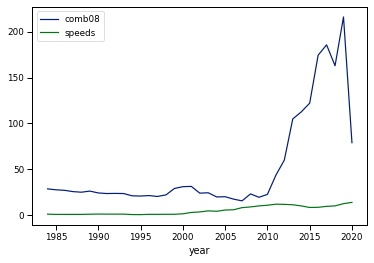

In [20]:
# can test multiple stuff easily
(
    autos2
    .groupby('year')
    [['comb08', 'speeds']]
    # .mean()
    # .median()
    # .quantile(.99) # 99% quantile
    # .std()
    .var()
    .plot()
)

In [21]:
def second_to_last(set):
    return set.iloc[-2]

(
    autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year', 'country']) # two axises + frequency
    .agg(['min', 'mean', second_to_last])
)

city08                           comb08             \
                min       mean second_to_last    min       mean   
year country                                                      
1984 Other        7  19.384615             14      8  21.417330   
     USA          8  16.079232             15      9  17.797119   
1985 Other        7  19.284768             19      8  21.373068   
     USA          8  16.275472             14     10  18.025157   
1986 Other        6  19.167183             10      7  21.213622   
     USA          9  15.945035             16     10  17.645390   
1987 Other        6  18.633381             12      7  20.710414   
     USA          8  15.611722             12      9  17.326007   
1988 Other        6  18.668224             12      7  20.814642   
     USA          8  15.577869             14      9  17.372951   
...             ...        ...            ...    ...        ...   
2016 Other       10  21.903749             28     12  24.439716   
     USA         11  25.061818             91     12  27.701818   
2017 Other       10  22.423795             21     11  24.910521   
     USA         11  24.003623            131     12  26.496377   
2018 Other        9  22.310442             11     11  24.779868   
     USA         11  23.526690            120     14  25.925267   
2019 Other        9  23.084221             19     11  25.456922   
     USA         11  24.169014            104     14  26.250000   
2020 Other       13  22.579487             17     15  25.174359   
     USA         20  24.071429             21     22  26.571429   

                            cylinders                              displ  ...  \
             second_to_last       min      mean second_to_last       min  ...   
year country                                                              ...   
1984 Other               14         2  4.908046              4  1.000000  ...   
     USA                 17         4  6.033613              6  1.400391  ...   
1985 Other               20         0  4.871965              4  0.000000  ...   
     USA                 15         3  5.949686              6  1.000000  ...   
1986 Other               11         0  4.804954              6  1.000000  ...   
     USA                 17         3  6.136525              6  1.000000  ...   
1987 Other               12         2  4.825963              4  1.000000  ...   
     USA                 13         3  6.164835              6  1.000000  ...   
1988 Other               12         2  4.819315              4  1.000000  ...   
     USA                 14         3  6.307377              6  1.000000  ...   
...                     ...       ...       ...            ...       ...  ...   
2016 Other               30         0  5.493414              4  0.000000  ...   
     USA                 93         0  5.356364              0  0.000000  ...   
2017 Other               24         0  5.431662              4  0.000000  ...   
     USA                126         0  5.532609              0  0.000000  ...   
2018 Other               12         0  5.396990              8  0.000000  ...   
     USA                116         0  5.597865              0  0.000000  ...   
2019 Other               22         0  5.315586              6  0.000000  ...   
     USA                104         0  5.559859              0  0.000000  ...   
2020 Other               20         0  5.148718              6  0.000000  ...   
     USA                 24         4  4.000000              4  1.400391  ...   

                      range automatic                          speeds  \
             second_to_last       min      mean second_to_last    min   
year country                                                            
1984 Other                0     False  0.550840          False      3   
     USA                  0     False  0.521059          False      3   
1985 Other                0     False  0.554084           True      3   
     USA             

solves it by unstacking


city08                comb08            cylinders            \
country      Other        USA      Other        USA     Other       USA   
year                                                                      
1984     19.384615  16.079232  21.417330  17.797119  4.908046  6.033613   
1985     19.284768  16.275472  21.373068  18.025157  4.871965  5.949686   
1986     19.167183  15.945035  21.213622  17.645390  4.804954  6.136525   
1987     18.633381  15.611722  20.710414  17.326007  4.825963  6.164835   
1988     18.668224  15.577869  20.814642  17.372951  4.819315  6.307377   
1989     18.533040  15.139831  20.662261  16.908898  4.879589  6.366525   
1990     18.510109  14.850575  20.640747  16.577011  4.839813  6.466667   
1991     18.087943  14.803279  20.174468  16.599532  5.029787  6.538642   
1992     17.915374  14.895631  20.098731  16.735437  5.145275  6.446602   
1993     18.084866  15.007772  20.309760  16.896373  5.114569  6.497409   
1994     18.046474  14.952514  20.264423  16.829609  5.185897  6.608939   
1995     17.678914  14.533724  20.091054  16.422287  5.444089  6.715543   
1996     18.480545  14.926641  20.906615  16.961390  5.147860  6.579151   
1997     18.090909  14.978632  20.509470  16.991453  5.261364  6.581197   
1998     17.925267  15.288000  20.457295  17.408000  5.275801  6.436000   
1999     17.925125  15.709163  20.386023  17.756972  5.377704  6.362550   
2000     17.881849  15.714844  20.301370  17.757812  5.441781  6.332031   
2001     17.941267  15.643939  20.289026  17.496212  5.479134  6.310606   
2002     17.644412  15.083916  20.076923  16.979021  5.576197  6.433566   
2003     17.565101  14.826087  19.953020  16.628763  5.683221  6.588629   
2004     17.426290  14.928571  19.923833  16.805195  5.729730  6.558442   
2005     17.412170  15.196610  19.892078  17.132203  5.773823  6.447458   
2006     17.062575  15.300366  19.509025  17.285714  5.977136  6.476190   
2007     16.996403  15.489726  19.452038  17.626712  6.044365  6.513699   
2008     17.239869  15.770073  19.677985  17.937956  6.095290  6.518248   
2009     17.696803  16.148014  20.186329  18.259928  5.970232  6.620939   
2010     18.325342  17.278970  20.851598  19.600858  5.897260  6.223176   
2011     19.247387  16.817844  21.635308  19.014870  5.851336  6.394052   
2012     19.838052  17.802974  22.339751  20.111524  5.792752  6.297398   
2013     20.982888  19.453815  23.471658  21.823293  5.658824  6.152610   
2014     21.159919  20.506329  23.655870  23.012658  5.719636  5.852321   
2015     21.350000  21.817490  23.935294  24.441065  5.604902  5.752852   
2016     21.903749  25.061818  24.439716  27.701818  5.493414  5.356364   
2017     22.423795  24.003623  24.910521  26.496377  5.431662  5.532609   
2018     22.310442  23.526690  24.779868  25.925267  5.396990  5.597865   
2019     23.084221  24.169014  25.456922  26.250000  5.315586  5.559859   
2020     22.579487  24.071429  25.174359  26.571429  5.148718  4.000000   

            displ             fuelCost08               highway08             \
country     Other       USA        Other          USA      Other        USA   
year                                                                          
1984     2.691406  3.808594  2118.125553  2578.871549  24.847038  20.669868   
1985     2.636719  3.765625  2141.997792  2553.899371  24.816777  21.020126   
1986     2.537109  3.925781  2149.148607  2588.741135  24.650155  20.464539   
1987     2.583984  3.931641  2227.318117  2630.036630  24.186876  20.208791   
1988     2.531250  4.066406  2207.476636  2623.258197  24.437695  20.420082   
1989     2.542969  4.171875  2250.000000  2698.093220  24.252570  19.887712   
1990     2.507812  4.265625  2238.258165  2728.735632  24.267496  19.485057   
1991     2.609375  4.351562  2348.581560  2725.761124  23.809929  19.683841   
1992     2.708984  4.250000  2373.272214  2703.762136  23.820874  20.063107   
1993     2.683594  4.281250  2333.097595  2677.202073  24.17256

smoothing the plot


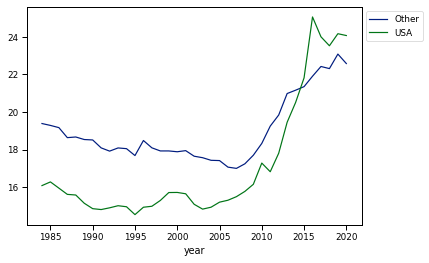

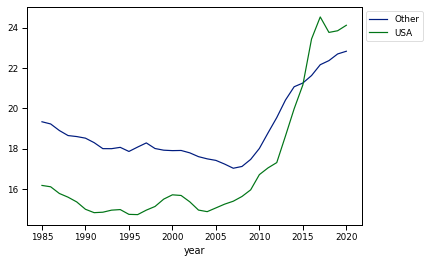

In [22]:
# has an issue with labeling due to multiple axis
# (
#     autos2
#     .assign(country=autos2.make.apply(country))
#     .groupby(['year', 'country'])
#     .mean()
#     .plot()
# )
# solves it by unstacking
print("solves it by unstacking")
display((
    autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year', 'country'])
    .mean()
    .unstack() # rotate country (unstacking) by sticking it to the columns
))
(
    autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year', 'country'])
    .mean()
    .unstack() # rotate country (unstacking) by sticking it to the columns
    .city08 # get the city08 column
    .plot()
    .legend(bbox_to_anchor=(1,1))
)
# smoothing the plot
print("smoothing the plot")
(
    autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year', 'country'])
    .mean()
    .unstack() # rotate country (unstacking) by sticking it to the columns
    .city08 # get the city08 column
    .rolling(2) # rolling window of 2, to smooth out the curve
    .mean()
    .plot()
    .legend(bbox_to_anchor=(1,1))
)

In [23]:
# someone's question: halfing results or something in SQL that might not be avaialble in Pandas
def vals_gt(df_, num):
    return df_[df_.gt(num)].dropna()
(
    autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year', 'country'])
    .count()
    .pipe(vals_gt, 700)
)

,,city08,comb08,cylinders,displ,drive,fuelCost08,highway08,make,range,createdOn,automatic,speeds,ffs
year,country,,,,,,,,,,,,,
1984,Other,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1131.0,1065.0
1985,Other,906.0,906.0,906.0,906.0,906.0,906.0,906.0,906.0,906.0,906.0,906.0,906.0,821.0
1991,Other,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
1992,Other,709.0,709.0,709.0,709.0,709.0,709.0,709.0,709.0,709.0,709.0,709.0,709.0,707.0
1993,Other,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0,707.0
2017,Other,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,1017.0,766.0
2018,Other,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,1063.0,844.0
2019,Other,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,1033.0,855.0
